In [1]:
mapping = {
    0: [[0, 12, 24], 'January'],
    1: [[1, 13, 25], 'February'],
    2: [[2, 14, 26], 'March'],
    3: [[3, 15, 27], 'April'],
    4: [[4, 16, 28], 'May'],
    5: [[5, 17, 29], 'June'],
    6: [[6, 18, 30], 'July'],
    7: [[7, 19, 31], 'August'],
    8: [[8, 20, 32], 'September'],
    9: [[9, 21, 33], 'October'],
    10: [[10, 22, 34], 'November'],
    11: [[11, 23, 35], 'December'],
}

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error



In [3]:

def select_columns_for_reading(path, dbn):
   
    columns = pd.read_csv(path, nrows=0).columns.tolist()

    cols = []
    for col in columns:
        l = col.split('$')
        if len(l) == 1:
            cols.append(col)
            continue

    return cols

In [4]:
SOURCE_PATH = '../validation/data/merged.csv'

In [5]:
cols = select_columns_for_reading(SOURCE_PATH,0)
merged = pd.read_csv(SOURCE_PATH, usecols=cols)

In [6]:

   
def parse_city(shop_name):

    if shop_name.split()[0] == '!Якутск':
        return  'Якутск'

    if shop_name.split()[0] == 'Сергиев':
            return  'Сергиев Посад'
    else:
        return shop_name.split()[0]

In [7]:
dbn_diff = pd.read_csv('../validation/data/item_dbn_diff.csv')
dbn_diff_selected = dbn_diff[['shop_id','item_id',*[str(i) for i in range(22,35)]]]
df_diff = pd.DataFrame({'shop_id':[], 'item_id':[],'date_block_num':[],'dbn_diff':[]})
for month in range(22,35):
    shop_id = dbn_diff_selected.shop_id
    item_id = dbn_diff_selected.item_id
    dbn = month
    diffs = dbn_diff_selected[str(month)]
    to_app = pd.DataFrame({'shop_id':shop_id, 'item_id':item_id,'date_block_num':[dbn] * len(item_id),'dbn_diff':diffs})
    df_diff=pd.concat([df_diff,to_app])

In [8]:
categories_f = pd.read_csv('../data_cleaned/item_categories.csv')
shops_f = pd.read_csv('../data_cleaned/shops.csv')

categories_f['super_category']=categories_f['item_category_name'].apply(lambda a: a.split()[0])
shops_f['city']=shops_f['shop_name'].apply(parse_city)


merged=merged.drop(['city'],axis=1)
merged=merged.drop(['super_category'],axis=1)
merged=merged.merge(shops_f, how='left').merge(categories_f, how='left')


In [9]:
#Assume that monthes are [22,34]  
preds = np.load('./val_preds.npy',allow_pickle=True)#preds_l.append(y_val_pred)
real = np.load('./val_true.npy',allow_pickle=True)#Y_true_l.append([np.array(Y_val).flatten(), np.array(shop_id).flatten(), np.array(item_id).flatten()])
errors = np.load('./val_errors.npy',allow_pickle=True)

In [10]:
preds[0]

array([array([0.07128714, 0.00637725, 0.01856017, ..., 0.01400191, 0.00829987,
              0.00601479])                                                    ],
      dtype=object)

In [11]:
df = pd.DataFrame({'shop_id':[], 'item_id':[],'date_block_num':[],'sales':[],'preds':[]})
for month in range(len(real)):
    month_num = month+22
    sales = real[month][:,0][0]
    shop_id=real[month][:,1][0]
    item_id=real[month][:,2][0]
    preds_val = preds[month][0]
    dbn = [month_num] * len(shop_id)
    to_app=pd.DataFrame({'shop_id':shop_id, 'item_id':item_id,'date_block_num':dbn,'sales':sales, 'preds':preds_val})
    df=pd.concat([df,to_app])



In [12]:
df=df.merge(merged).merge(df_diff)

In [13]:
df

,shop_id,item_id,date_block_num,sales,preds,item_category_id,shop_name,city,item_category_name,super_category,dbn_diff
0,40.0,19597.0,22.0,0.0,0.071287,40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",РостовНаДону,Кино - DVD,Кино,22.0
1,24.0,17744.0,22.0,0.0,0.006377,75,"Москва ТК ""Буденовский"" (пав.К7)",Москва,Программы - Для дома и офиса,Программы,22.0
2,30.0,19681.0,22.0,0.0,0.018560,37,"Москва ТЦ ""Перловский""",Москва,Кино - Blu-Ray,Кино,19.0
3,24.0,847.0,22.0,0.0,0.000000,78,"Москва ТК ""Буденовский"" (пав.К7)",Москва,Программы - Обучающие (Цифра),Программы,18.0
4,18.0,6624.0,22.0,1.0,0.171997,22,"Красноярск ТЦ ""Июнь""",Красноярск,Игры - PSVita,Игры,20.0
...,...,...,...,...,...,...,...,...,...,...,...
3114243,14.0,12118.0,33.0,0.0,0.032492,16,"Казань ТЦ ""ПаркХаус"" II",Казань,Игровые консоли - XBOX ONE,Игровые,10.0
3114244,39.0,5962.0,33.0,1.0,0.077128,55,"РостовНаДону ТРК ""Мегацентр Горизонт""",РостовНаДону,Музыка - CD локального производства,Музыка,19.0
3114245,56.0,16809.0,33.0,0.0,0.002301,78,"Чехов ТРЦ ""Карнавал""",Чехов,Программы - Обучающие (Цифра),Программы,11.0
3114246,15.0,15740.0,33.0,0.0,0.108334,55,"Калуга ТРЦ ""XXI век""",Калуга,Музыка - CD локального производства,Музыка,32.0


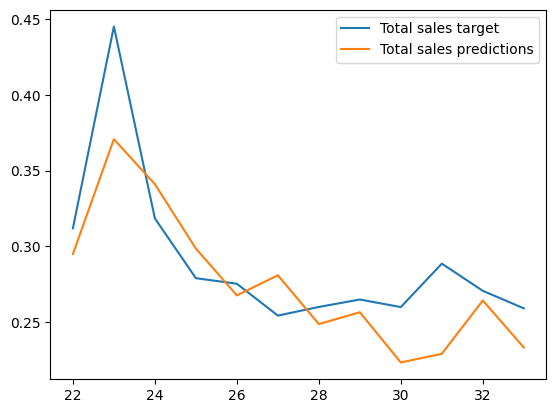

In [14]:
total_sails=df.groupby('date_block_num').agg({'sales':'mean','preds':'mean'})

plt.plot(np.arange(22,34,dtype=int),total_sails['sales'], label='Total sales target' )
plt.plot(np.arange(22,34,dtype=int),total_sails['preds'], label='Total sales predictions' )
plt.legend()

In [15]:
def diff(target, pred):
    return target-pred
def mse(target, pred):
    return (target-pred)**2

def mae(target, pred):
    return np.abs(target-pred)


def smape(A,F):
    return 100 * (2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def mape(A,F):
    return 100 * np.abs(F - A) / np.abs(A)

In [16]:
df['mae_errors'] = mae(df['preds'] , df['sales'] )
df['smape_errors'] = smape(df['preds'] , df['sales'] ).fillna(0)
df['diff'] = diff(df['preds'] , df['sales'] )

In [17]:
df_this=df.groupby('date_block_num')['diff'].describe().reset_index()
df_this.loc['mean'] = df_this.mean()
df_this

,date_block_num,count,mean,std,min,25%,50%,75%,max
0,22.0,316050.000000,-0.016960,0.960187,-19.944335,0.005100,0.033886,0.123945,16.601228
1,23.0,330000.000000,-0.074378,1.120713,-19.916730,0.011695,0.037524,0.140044,14.044350
2,24.0,306800.000000,0.022550,0.799675,-20.000000,0.005864,0.037870,0.152980,20.000000
3,25.0,284303.000000,0.019557,0.798095,-19.994571,0.004357,0.032557,0.141304,20.000000
4,26.0,279588.000000,-0.007701,0.756133,-19.307700,0.004564,0.030202,0.132568,19.149806
5,27.0,246285.000000,0.026590,0.883607,-19.760527,0.005517,0.040602,0.157137,18.000000
6,28.0,232452.000000,-0.011286,0.811060,-19.927290,0.005178,0.032765,0.131303,14.853557
7,29.0,224116.000000,-0.008394,0.790201,-19.688682,0.004522,0.029128,0.130169,19.461319
8,30.0,228674.000000,-0.036558,0.705183,-19.996016,0.002493,0.023340,0.109412,12.099435
9,31.0,214410.000000,-0.059495,0.771254,-19.803445,0.003296,0.024832,0.120835,19.600811


From the plot and  table above we can see, that model is more likely to underpedict

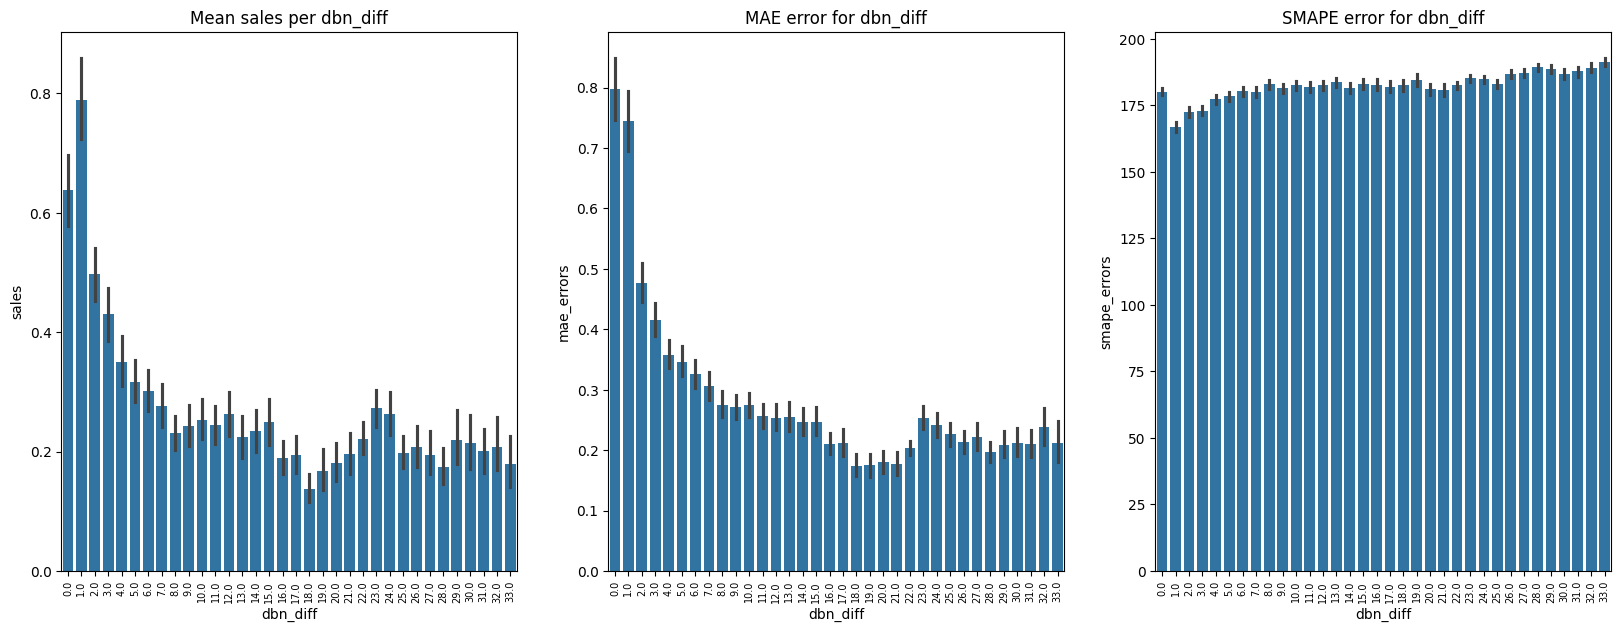

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20,7))
df_sel = df.sample(n=100000)

sns.barplot(x=df_sel['dbn_diff'],y=df_sel['sales'],ax=ax[0])
ax[0].set_title('Mean sales per dbn_diff')
ax[0].tick_params(axis='x', labelrotation=90,labelsize=7)

sns.barplot(x=df_sel['dbn_diff'],y=df_sel['mae_errors'],ax=ax[1])
sns.barplot(x=df_sel['dbn_diff'],y=df_sel['smape_errors'],ax=ax[2])
ax[1].tick_params(axis='x', labelrotation=90,labelsize=7)
ax[1].set_title('MAE error for dbn_diff')
ax[2].tick_params(axis='x', labelrotation=90,labelsize=7)
ax[2].set_title('SMAPE error for dbn_diff');

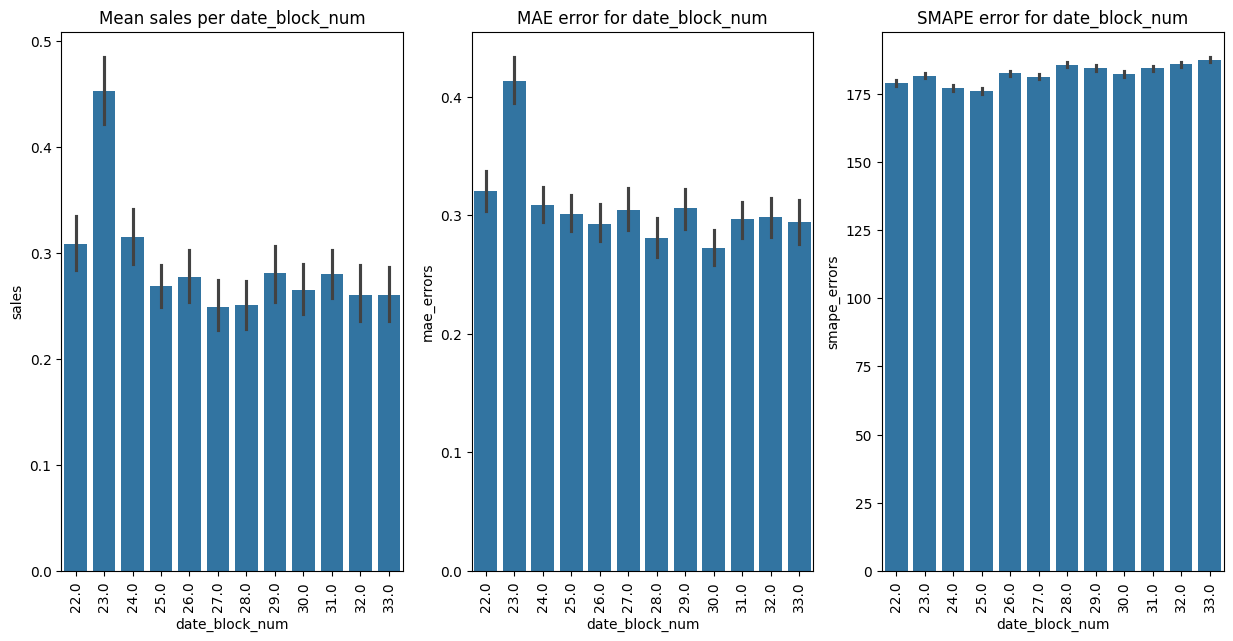

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
df_sel = df.sample(n=100000)

sns.barplot(x=df_sel['date_block_num'],y=df_sel['sales'],ax=ax[0])
ax[0].set_title('Mean sales per date_block_num')
ax[0].tick_params(axis='x', labelrotation=90)

sns.barplot(x=df_sel['date_block_num'],y=df_sel['mae_errors'],ax=ax[1])
sns.barplot(x=df_sel['date_block_num'],y=df_sel['smape_errors'],ax=ax[2])
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('MAE error for date_block_num')
ax[2].tick_params(axis='x', labelrotation=90)
ax[2].set_title('SMAPE error for date_block_num');

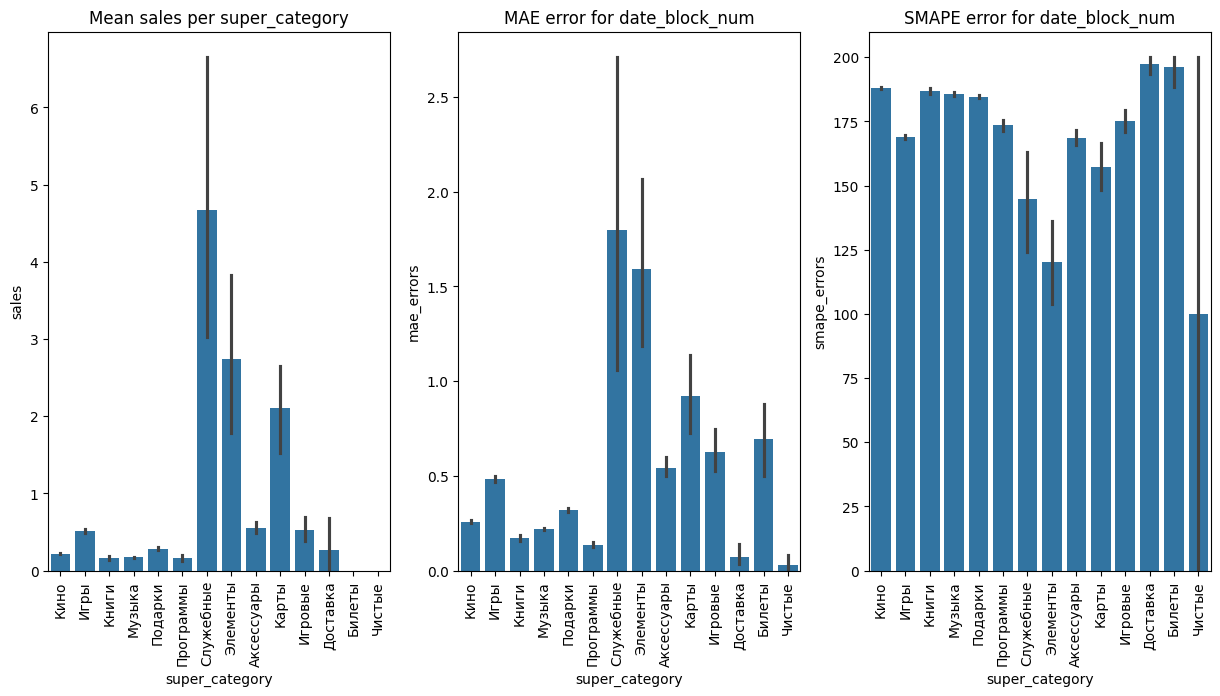

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
df_sel = df.sample(n=100000)

sns.barplot(x=df_sel['super_category'],y=df_sel['sales'],ax=ax[0])
ax[0].set_title('Mean sales per super_category')
ax[0].tick_params(axis='x', labelrotation=90)

sns.barplot(x=df_sel['super_category'],y=df_sel['mae_errors'],ax=ax[1])
sns.barplot(x=df_sel['super_category'],y=df_sel['smape_errors'],ax=ax[2])
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('MAE error for date_block_num')
ax[2].tick_params(axis='x', labelrotation=90)
ax[2].set_title('SMAPE error for date_block_num');

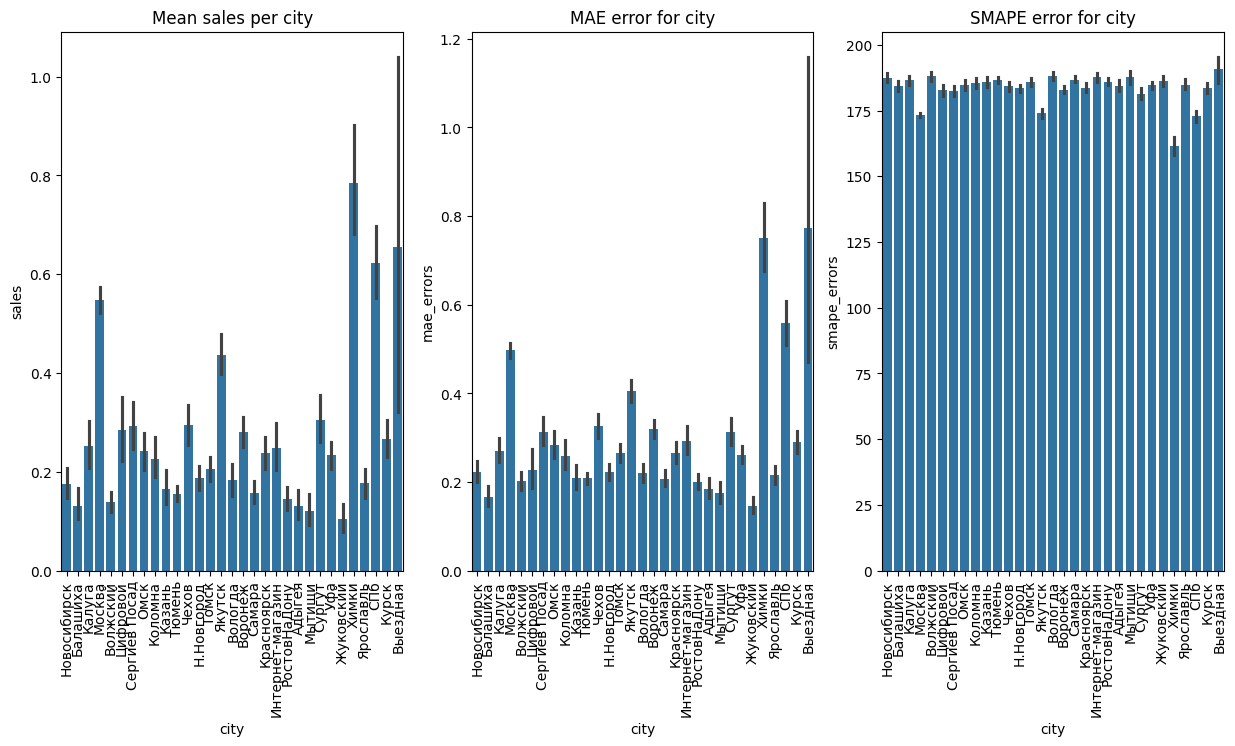

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,7))
df_sel = df.sample(n=100000)

sns.barplot(x=df_sel['city'],y=df_sel['sales'],ax=ax[0])
ax[0].set_title('Mean sales per city')
ax[0].tick_params(axis='x', labelrotation=90)

sns.barplot(x=df_sel['city'],y=df_sel['mae_errors'],ax=ax[1])
sns.barplot(x=df_sel['city'],y=df_sel['smape_errors'],ax=ax[2])
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('MAE error for city')
ax[2].tick_params(axis='x', labelrotation=90)
ax[2].set_title('SMAPE error for city');

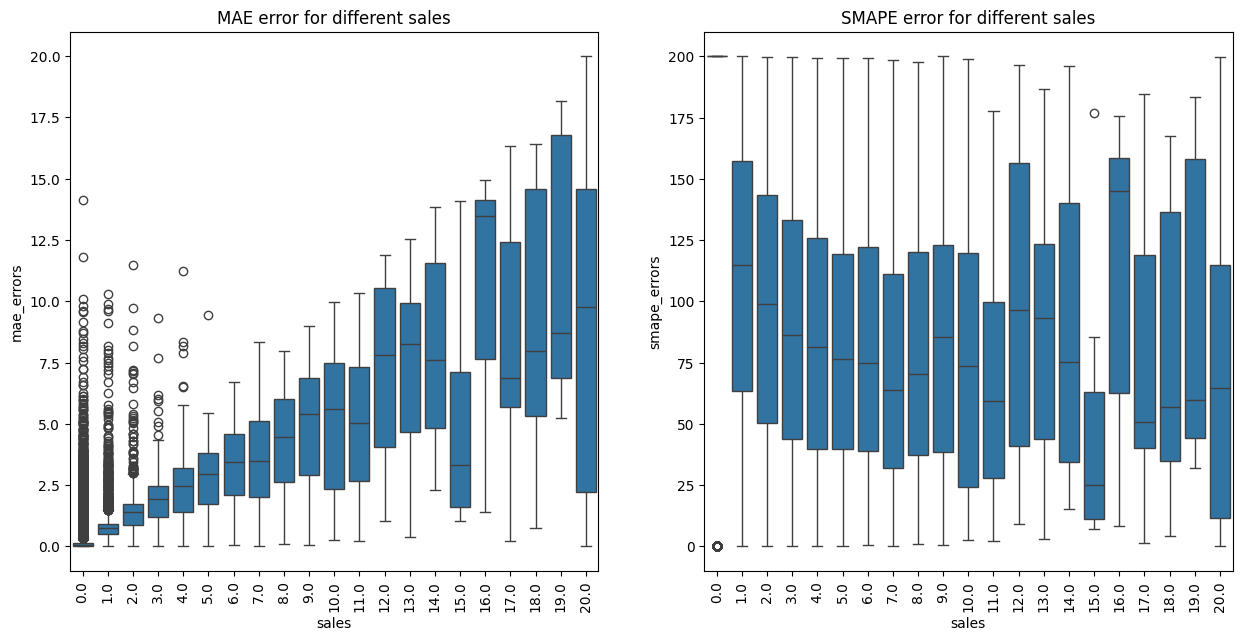

In [22]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
df_sel = df.sample(n=100000)
sns.boxplot(x=df_sel['sales'],y=df_sel['mae_errors'],ax=ax[0])
sns.boxplot(x=df_sel['sales'],y=df_sel['smape_errors'],ax=ax[1])

ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('MAE error for different sales')

ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('SMAPE error for different sales');
#SMAPE is undefined in 0

From the plots above we can see, that errors depends on sales - the more the sales - the more mean error.
Also we can see, that there is no feature, where error obvioulsy depends on its value. Some features have different mean errors for different values, but, in my opinion, it may be explained by total sales for each feature value

Now lets explore elements where model overpredicts extremely 

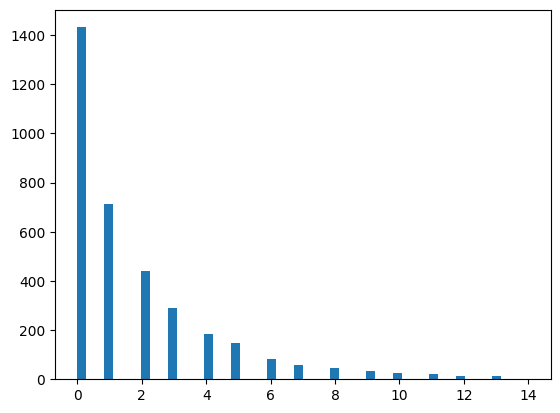

In [23]:
df_large_errors = df.query('diff > 5')
plt.hist(df_large_errors.sales,bins=50);

Model extremely  overpredicts mostly for elements where sales is small

Now lets explore elements where model underpredicts extremely 

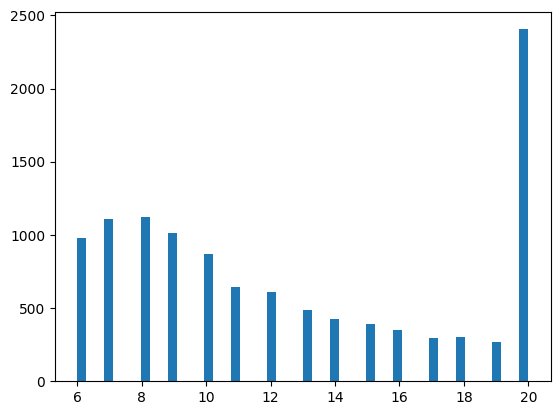

In [24]:
df_large_errors = df.query('diff < -5')
plt.hist(df_large_errors.sales,bins=50);

Model extremely  underpredicts mostly for elements where sales is 20

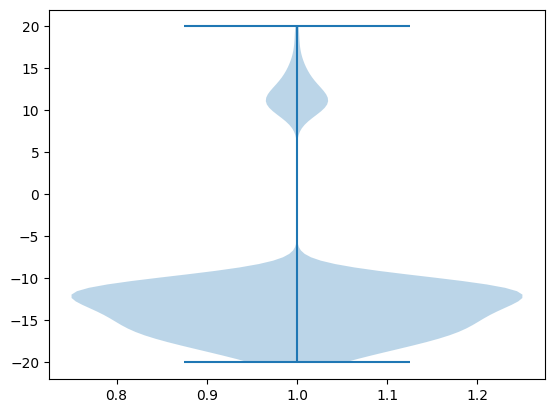

In [25]:
df_large_errors = df.query('mae_errors > 10')
plt.violinplot(df_large_errors['diff']);


We can see, that "extreme underprediction" is much more likely for our model than "extreme overprediction"

Extreme (mae > 19) errors exploration

In [26]:
df_large_errors = df.query('mae_errors  > 19')
print('Overpreicted:',(df_large_errors['diff'] > 0).sum())
print('Underrpreicted:',(df_large_errors['diff'] < 0).sum())

Overpreicted: 8
Underrpreicted: 144


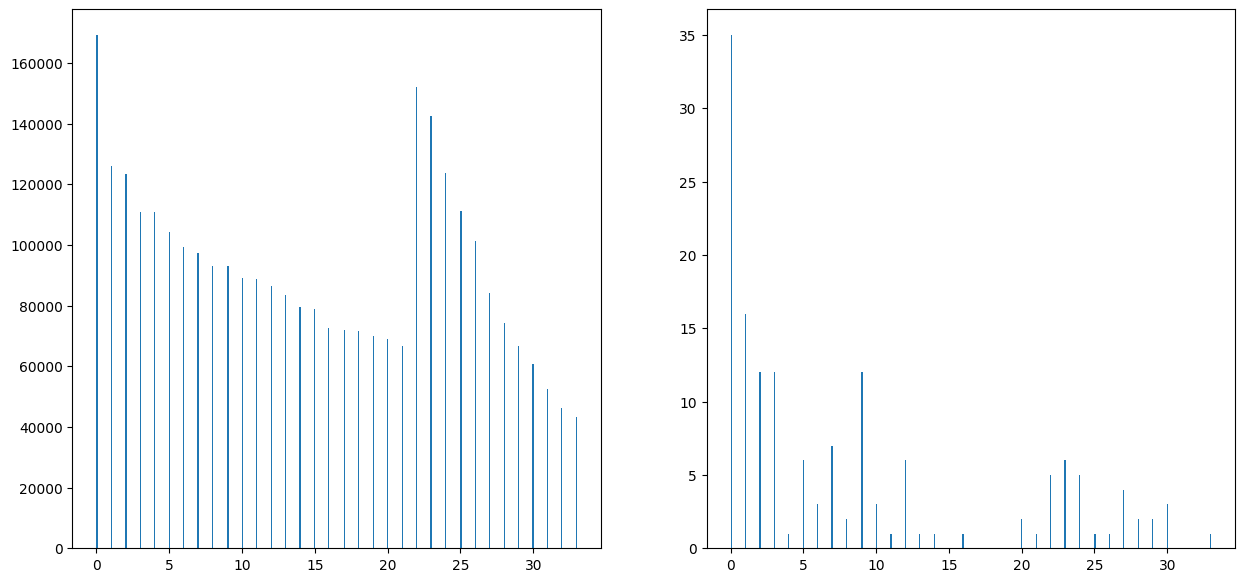

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
ax[0].hist(df.dbn_diff,bins=400)
ax[1].hist(df_large_errors.dbn_diff, bins=400);

We can see, that date block num difference have influence on large errors (especially, when  date block num difference == 0)

In [28]:
df_large_errors.query('dbn_diff > 1').item_id.value_counts()

item_id
20949.0    13
15346.0     6
8452.0      5
22162.0     4
3326.0      2
           ..
2431.0      1
16844.0     1
13332.0     1
17270.0     1
13331.0     1
Name: count, Length: 70, dtype: int64

We can see that there are only few items which have extreme error after entering the market

In [29]:
df_selected = df.query('item_id== 20949')
df_selected.shop_name.unique()

array(['СПб ТК "Невский Центр"', 'Москва МТРЦ "Афи Молл"',
       'Воронеж ТРЦ "Максимир"', 'Москва ТРК "Атриум"',
       'Н.Новгород ТРЦ "Фантастика"', 'Курск ТЦ "Пушкинский"',
       'Интернет-магазин ЧС', 'Волжский ТЦ "Волга Молл"',
       'РостовНаДону ТРК "Мегацентр Горизонт"', 'Мытищи ТРК "XL-3"',
       'СПб ТК "Сенная"', 'Москва ТЦ "МЕГА Теплый Стан" II',
       'Красноярск ТЦ "Взлетка Плаза"', 'Коломна ТЦ "Рио"',
       'Химки ТЦ "Мега"', 'Н.Новгород ТРЦ "РИО"',
       'РостовНаДону ТЦ "Мега"', 'Калуга ТРЦ "XXI век"',
       'Якутск ТЦ "Центральный"', 'Якутск Орджоникидзе, 56',
       'Ярославль ТЦ "Альтаир"', 'Уфа ТЦ "Семья" 2',
       'Москва ТЦ "Новый век" (Новокосино)', 'Самара ТЦ "ПаркХаус"',
       'Томск ТРЦ "Изумрудный Город"', 'Воронеж (Плехановская, 13)',
       'Казань ТЦ "ПаркХаус" II', 'Адыгея ТЦ "Мега"',
       'Тюмень ТЦ "Гудвин"', 'Москва ТЦ "Перловский"',
       'Уфа ТК "Центральный"', 'Тюмень ТРЦ "Кристалл"',
       'Чехов ТРЦ "Карнавал"', 'Красноярск ТЦ "Июн

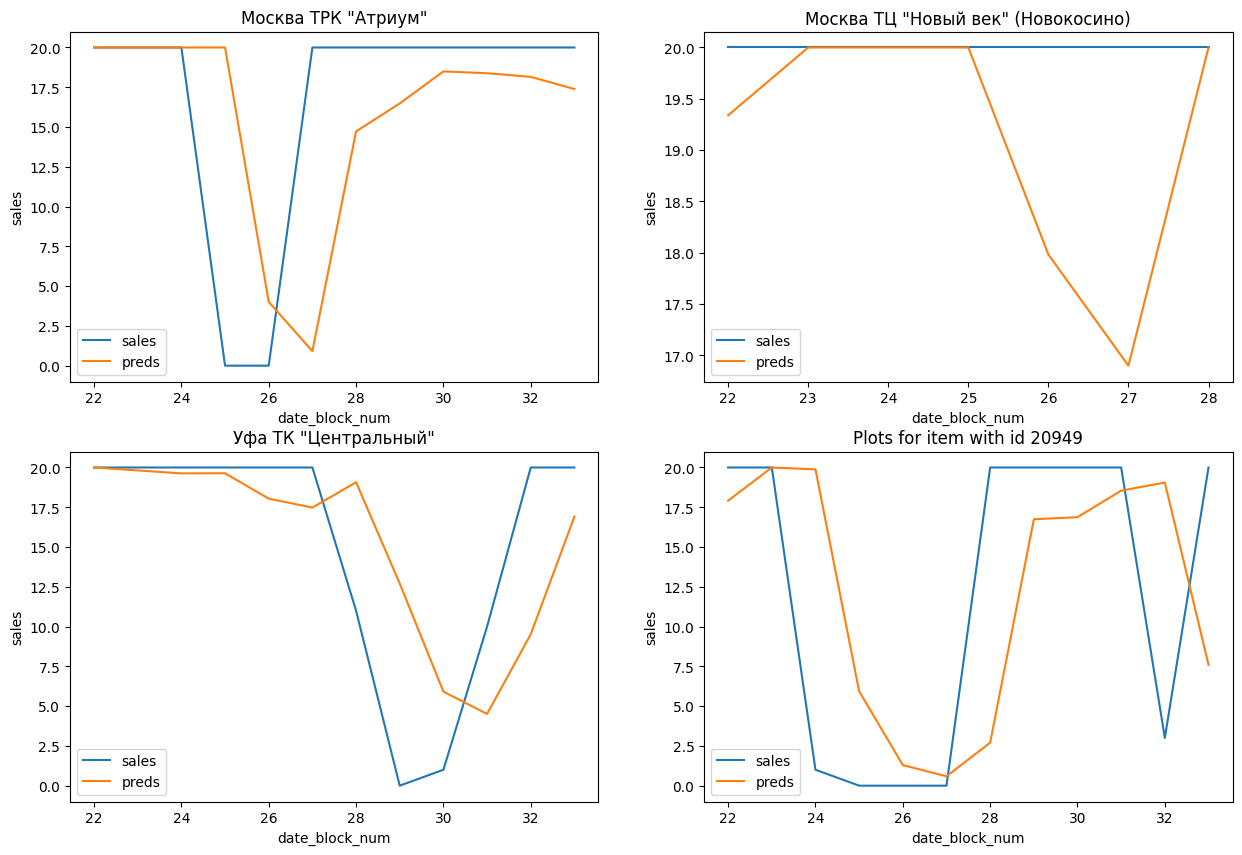

In [30]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

df_selected_shop1=df_selected[df_selected['shop_name']=='Москва ТРК \"Атриум\"']
sns.lineplot(df_selected_shop1[['date_block_num','sales']], x='date_block_num',y='sales',label='sales', ax=ax[0,0])
sns.lineplot(df_selected_shop1[['date_block_num','preds']], x='date_block_num',y='preds',label='preds',ax=ax[0,0])
ax[0,0].set_title('Москва ТРК \"Атриум\"')

df_selected_shop2=df_selected[df_selected['shop_name']=='Москва ТЦ \"Новый век\" (Новокосино)']
sns.lineplot(df_selected_shop2[['date_block_num','sales']], x='date_block_num',y='sales',label='sales', ax=ax[0,1])
sns.lineplot(df_selected_shop2[['date_block_num','preds']], x='date_block_num',y='preds',label='preds',ax=ax[0,1])
ax[0,1].set_title('Москва ТЦ \"Новый век\" (Новокосино)')

df_selected_shop3=df_selected[df_selected['shop_name']=="Уфа ТК \"Центральный\""]
sns.lineplot(df_selected_shop3[['date_block_num','sales']], x='date_block_num',y='sales',label='sales', ax=ax[1,0])
sns.lineplot(df_selected_shop3[['date_block_num','preds']], x='date_block_num',y='preds',label='preds',ax=ax[1,0])
ax[1,0].set_title("Уфа ТК \"Центральный\"")

df_selected_shop4=df_selected[df_selected['shop_name']=="РостовНаДону ТЦ \"Мега\""]
sns.lineplot(df_selected_shop4[['date_block_num','sales']], x='date_block_num',y='sales',label='sales', ax=ax[1,1])
sns.lineplot(df_selected_shop4[['date_block_num','preds']], x='date_block_num',y='preds',label='preds',ax=ax[1,1])
ax[1,1].set_title("РостовНаДону ТЦ \"Мега\"")

plt.title('Plots for item with id 20949');

We can see, that model may have big errors when item dissapear from shops (even part of shops)

Also we can see, that predictions may try to reproduce sales from last month

Conclusion:
1) Samples with large sales make much more contribution to error
2) 144/152 % of "extreme (>19)" errors occurs for underpreicted samples
3) Lots of extreme errors occurs when dbn_diff=0
4) Items which dissapear from shops and then restored may give large errors